# Finite Element Methods

Finite element methods discretize weak forms directly by choosing discrete subspaces for test and trial functions.  So an equation: find $u \in V$ such that
$$ \int_{\Omega} \nabla v \cdot \kappa \cdot \nabla u = 0, \quad \text{for all } v \in V $$
becomes: find $u_h \in V_h$ such that
$$ \int_{\Omega} \nabla v_h \cdot \kappa \cdot \nabla u_h = 0, \quad \text{for all } v_h \in V_h . $$
The integral is usually computed using quadrature which may or may not be exact.

To implement finite element methods, we need to define the discrete spaces $V_h$.  Usually these will be piecewise polynomial with some continuity between elements.  We'll start by working on a single element $(-1, 1)$ and will use a monomial basis for the moment, then provide a formal definition of finite elements and a more general construction.

## Quadrature

Finite element methods require numerical integration of weak forms.  This is usually done by **quadrature**

$$ \int_{-1}^1 f(x) \approx \sum_{i=1}^n w_i f(q_i) . $$
There are many ways to choose the points $q_i$ and weights $w_i$.  For example, the trapezoid rule is a quadrature.

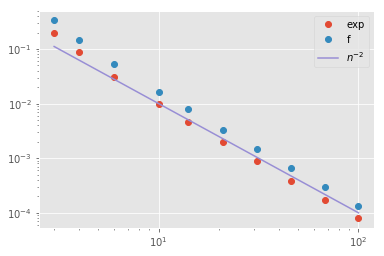

In [1]:
%matplotlib inline
import numpy
from matplotlib import pyplot
pyplot.style.use('ggplot')

def quad_trapezoid(n):
    q = numpy.linspace(-1, 1, n)
    w = 0*q + 2/(n-1)
    w[[0,-1]] /= 2
    return q, w

def plot_quad_accuracy(fs, quad):
    ns = numpy.logspace(.5, 2, 10, dtype=int)
    for f, F in fs:
        exact = F(1) - F(-1)
        def err(n):
            q, w = quad(n)
            return w.dot(f(q)) - exact
        errors = [numpy.abs(err(n)) for n in ns]
        pyplot.loglog(ns, errors, 'o', label=f.__name__)
    pyplot.loglog(ns, ns**(-2.), label='$n^{{-2}}$')
    pyplot.legend()

def poly(p):
    def f(x):
        return numpy.polyval(p, x)
    pint = numpy.polyint(p)
    def F(x):
        return numpy.polyval(pint, x)
    return f, F
    
plot_quad_accuracy([(numpy.exp, numpy.exp),
                    poly([1,2,3])],
                   quad_trapezoid)

### Gauss quadrature

Methods like the trapezoid rule are inefficient for integrating polynomials and related functions, in the sense that they need many points to reach desired accuracy tolerances.  Gauss quadrature is a spectrally accurate method that can exactly integrate polynomials of degree $2n-1$ using $n$ points.  To derive Gauss quadrature, we will need the Legendre polynomials $P_n(x)$, first discovered in the early 19th century as eigenfunctions (resonant modes) of the differential operator
$$ \frac{d}{d x} (1 - x^2) \frac{d P_n(x)}{dx} $$
on the interval $(-1, 1)$.
Legendre polynomials can also be derived by applying Gram-Schmidt orthogonalization to the monomials using the inner product
$$ \langle P_m, P_n \rangle = \int_{-1}^1 P_m(x) P_n(x) $$
and a normalization convention that $P_n(1) = 1$.
In practice, we will use the recursive definition
$$\begin{split}
P_0(x) &= 1 \\
P_1(x) &= x \\
(n+1) P_{n+1}(x) &= (2n+1) x P_n(x) - n P_{n-1}(x)
\end{split}$$

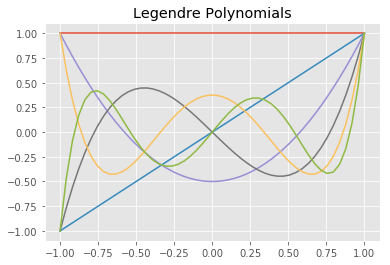

In [2]:
def vander_legendre(x, n=None):
    if n is None:
        n = len(x)
    P = numpy.ones((len(x), n))
    if n > 1:
        P[:,1] = x
    for k in range(1,n-1):
        P[:,k+1] = ((2*k+1) * x * P[:,k] - k * P[:,k-1]) / (k + 1)
    return P

x = numpy.linspace(-1, 1)
P = vander_legendre(x, 6)
pyplot.figure()
pyplot.plot(x, P)
pyplot.title('Legendre Polynomials');

Since the polynomials $P_n$ are orthogonal to $P_0(x) = 1$ in particular,
$$ \int_{-1}^1 P_n(x) = 0, \quad n=1,2,\dotsc $$
which means that we can integrate an arbitrary function by writing the Lagrange interpolating polynomial in the Legendre basis
$$ p_n(x) = \sum_{i=0}^n c_i P_i(x) $$
and integrating
$$ \int_{-1}^1 p_n(x) = 2 c_0 . $$

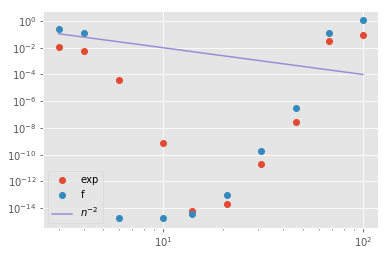

In [3]:
def quad_lin_legendre(n):
    q = numpy.linspace(-1, 1, n)
    P = vander_legendre(q)
    w = 2*numpy.linalg.solve(P.T, numpy.eye(n, 1)).flatten()
    return q, w

plot_quad_accuracy([(numpy.exp, numpy.exp),
                    poly([1,2,3,4,5])],
                   quad_lin_legendre)

This is quite accurate when using just a few points, but becomes unstable due to the [Runge phenomenon](https://en.wikipedia.org/wiki/Runge%27s_phenomenon).  We could control this by choosing `cosspace` points like we did for Chebyshev methods, but it is possible to do much better.  Suppose we write a polynomial on the interval $(-1,1)$ as

$$ p_{2n-1}(x) = P_n(x) q(x) + r(x) $$

where $P_n(x)$ is the $n$th Legendre polnomials and both $q(x)$ and $r(x)$ are polynomials of maximum degree $n-1$.

* Can every polynomials of degree $2n-1$ be written in the above form?
* How many roots does $P_n(x)$ have on the interval?
* Can we choose points $\{x_i\}$ such that the first term is 0?

If $P_n(x_i) = 0$ for each $x_i$, then we need only integrate $r(x)$, which is done exactly by integrating its interpolating polynomial.  How do we find these roots $x_i$?

#### Derivatives of Legendre Polynomials

The derivatives of Legendre polynomials satisfy a recurrence,
$$ P_{n+1}'(x) = (2n+1) P_n(x) + P_{n-1}'(x) . $$

With the ability to compute $P_n(x)$ and $P_n'(x)$, we can use Newton's method to compute the roots.
It turns out that `cos(linspace(.5/n, 1-.5/n, n) * pi)` is a good initial guess.

[0] 4.592793e-01 [ -8.66025404e-01   6.12323400e-17   8.66025404e-01]
[1] 5.521014e-02 [-0.78729582  0.          0.78729582]
[2] 1.276900e-03 [-0.77489746  0.          0.77489746]
[3] 7.426670e-07 [-0.77459684  0.          0.77459684]
[4] 2.514241e-13 [-0.77459667  0.          0.77459667]
|w1 - w2| = 1.802206e-13


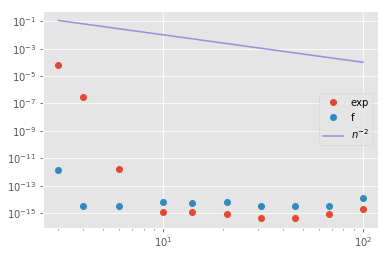

In [4]:
def vander_legendre_deriv(x, n=None):
    if n is None:
        n = len(x)
    P = numpy.ones((len(x), n))
    dP = numpy.zeros_like(P)
    if n > 1:
        P[:,1] = x
        dP[:,1] = 1
    for k in range(1,n-1):
        P[:,k+1] = ((2*k+1) * x * P[:,k] - k * P[:,k-1]) / (k + 1)
        dP[:,k+1] = (2*k+1) * P[:,k] + dP[:,k-1]
    return P, dP

def quad_gauss_legendre(n, verbose=False):
    q = numpy.cos(numpy.linspace(-1+.5/n, -.5/n, n) * numpy.pi)
    for i in range(20):
        P, dP = vander_legendre_deriv(q, n+1)
        Pn = P[:,-1]
        dPn = dP[:,-1]
        if verbose:
            print('[{:d}] {:10e} {}'.format(i, numpy.linalg.norm(Pn), q))
        if numpy.linalg.norm(Pn) < 1e-12:
            break
        q -= Pn / dPn
    w1 = 2*numpy.linalg.solve(P[:,:-1].T, numpy.eye(n, 1)).flatten()
    w2 = 2 / ((1-q**2)*dPn**2) # There is a closed form solution
    if verbose:
        print('|w1 - w2| = {:10e}'.format(numpy.linalg.norm(w1 - w2)))
    return q, w2

quad_gauss_legendre(3, verbose=True)
plot_quad_accuracy([(numpy.exp, numpy.exp),
                    poly([1,2,3,4,5])],
                   quad_gauss_legendre)

## Interpolation nodes

We will define the finite element solution $u_h \in V_h$ by the Lagrange interpolating polynomials on some set of nodes $x_i$.

cond 2.841185e+00


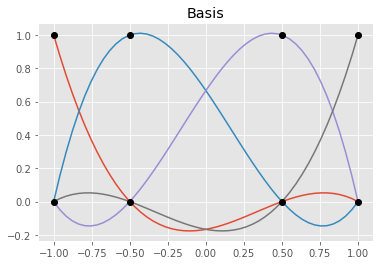

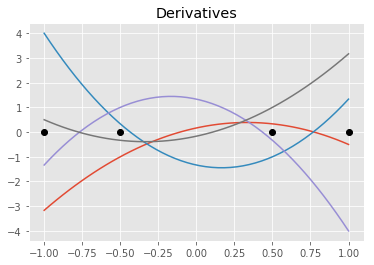

In [5]:
%run fdtools.py

def cosspace(a, b, n=50):
    return (a + b)/2 + (b - a)/2 * (numpy.cos(numpy.linspace(-numpy.pi, 0, n)))

x = numpy.linspace(-1, 1, 10)
x = cosspace(-1, 1, 4)

def febasis(x, q):
    B = numpy.zeros((len(q), len(x)))
    D = numpy.empty_like(B)
    for i, qi in enumerate(q):
        c = fdstencil(qi, x, nderiv=1)
        B[i] = c[0]
        D[i] = c[1]
    return B, D

xx = numpy.linspace(-1, 1)
B, D = febasis(x, xx)
pyplot.plot(xx, B)
pyplot.plot(x, 0*x, 'ok')
pyplot.plot(x, 0*x+1, 'ok')
pyplot.title('Basis');
pyplot.figure()
pyplot.plot(xx, D)
pyplot.plot(x, 0*x, 'ok')
pyplot.title('Derivatives')
print('cond {:10e}'.format(numpy.linalg.cond(B)))

## Galerkin method

### $L^2$ projection

$L^2$ projection refers to the problem: find $u \in V_h$ such that
$$ \int_{-1}^1 v(x) \big[ u(x) - f(x) \big] = 0, \quad \text{for all } v \in V_h$$
and is an excellent first test problem because it does not require derivatives.  This projection should be exact if $f(x) \in V_h$.

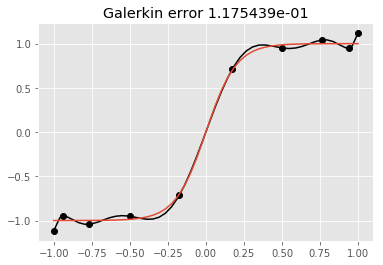

In [6]:
def L2_galerkin(n, f):
    x = cosspace(-1, 1, n)
    q, w = quad_gauss_legendre(n)
    B, D = febasis(x, q)
    rhs = B.T @ (w * f(q))
    A = B.T * w @ B
    u = numpy.linalg.solve(A, rhs)
    return x, u

def plot_galerkin(x, u, f):
    q = numpy.linspace(-1, 1)
    B, _ = febasis(x, q)
    pyplot.plot(x, u, 'ok')
    pyplot.plot(q, B@u, '-k')
    pyplot.plot(q, f(q))
    pyplot.title('Galerkin error {:8e}'.format(numpy.linalg.norm(B@u - f(q), numpy.inf)))

def tanh5(x):
    return numpy.tanh(5*x)
x, u = L2_galerkin(10, tanh5)
plot_galerkin(x, u, tanh5)

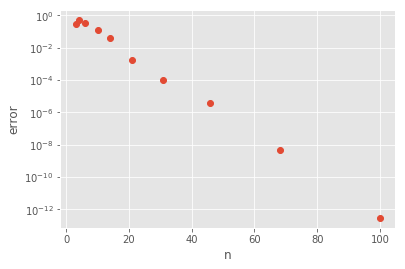

In [7]:
def L2_galerkin_convergence(f):
    ns = numpy.logspace(.5, 2, 10, dtype=int)
    def error(n):
        x, u = L2_galerkin(n, f)
        return numpy.linalg.norm(u - f(x), numpy.inf)
    errors = [error(n) for n in ns]
    pyplot.semilogy(ns, errors, 'o')
    pyplot.xlabel('n')
    pyplot.ylabel('error')
    
L2_galerkin_convergence(tanh5)

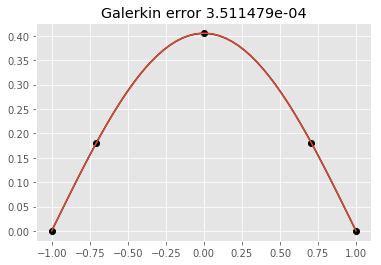

In [8]:
def laplace_galerkin(n, f):
    x = cosspace(-1, 1, n)
    q, w = quad_gauss_legendre(n)
    B, D = febasis(x, q)
    rhs = B.T @ (w * f(q))
    A = D.T * w @ D
    A[0] = 0
    A[0,0] = 1
    rhs[0] = 0
    A[-1] = 0
    A[-1,-1] = 1
    rhs[-1] = 0
    u = numpy.linalg.solve(A, rhs)
    return x, u

x, u = laplace_galerkin(5, lambda x: numpy.cos(x*numpy.pi/2))
plot_galerkin(x, u, lambda x: numpy.cos(x*numpy.pi/2)*(2/numpy.pi)**2)

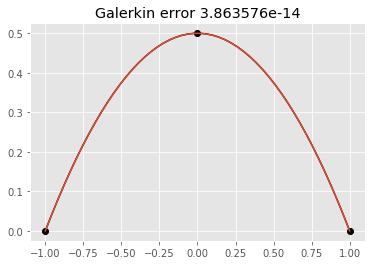

In [9]:
x, u = laplace_galerkin(3, lambda x:0*x+1)
plot_galerkin(x, u, lambda x:.5*(1 - x**2))

## Error estimates

We introduce the notation
$$ a(v, u) = \int_\Omega \nabla v(x) \cdot \nabla u(x) $$
and note that $a$ is
* bilinear (linear in each of its arguments)
* symmetric: $a(u, v) = a(v,u)$
* positive definite: $a(u, u) > 0$ when $u \ne 0$
thus defines an inner product on the function space $V$.
We also introduce the $L^2$ inner product
$$ \langle u, v \rangle = \int_\Omega u(x) v(x) $$
so that our continuous weak form is to find $u \in V$ such that
$$ a(v, u) = \langle v, f \rangle, \quad \forall v\in V. $$
Our Galerkin discretization is to find $u_h \in V_h \subset V$ such that
$$ a(v_h, u_h) = \langle v_h, f \rangle, \quad \forall v_h \in V_h . $$
Since $V_h \subset V$, we can subtract these two, yielding
$$ a(v_h, u_h - u) = 0, \quad \forall v_h \in V_h .$$
This says that the error in the discrete solution $u_h - u$ is $a$-orthogonal to all test functions $v_h$.

We can also define the "energy norm" or $a$-norm,
$$ \lVert u \rVert_a = \sqrt{a(u,u)} . $$
This norm satisfies the Cauchy-Schwarz inequality,
$$ \lvert a(u,v) \rvert \le \lVert u \rVert_a \lVert v \rVert_a . $$
Now,
\begin{align}
\lVert u_h - u \rVert_a^2 &= a(u_h - u, u_h - u) \\
&= a(u_h - v_h, u_h - u) + a(v_h - u, u_h - u) \\
&= a(v_h - u, u_h - u) \\
&\le \lVert v_h - u \rVert_a \lVert u_h - u \rVert_a .
\end{align}
In other words,
$$\lVert u_h - u \rVert_a \le \lVert v_h - u \rVert_a, \quad \forall v_h \in V_h .$$
So the solution $u_h$ computed by the Galerkin discretization is optimal over the subspace $V_h$ as measured in the $a$-norm.

#### Observations
* The Galerkin method computes the exact solution any time it resides in the subspace $V_h$.
* The Galerkin method is automatically symmetric any time the weak form is symmetric.
* The Galerkin method can be spectrally accurate, similar to the Chebyshev finite difference methods.
* For a nonlinear problem, discretization and differentiation will commute.

## Finite elements

### Ciarlet definition

Ciarlet (1978) defines a **finite element** as a triple $(K, P, N)$ where
* $K$ is a bounded subset of $R^n$.
* $P = \mathrm{span} \{p_i(x)\}$ is a finite dimensional space of functions on $\bar K$.  This is called the "prime basis" and is often a collection of polynomials.  It should be easy to evaluate and differentiate at arbitrary points.
* $N = \{ n_i \}$ is a set of nodes such that the square matrix $V_{ij} = n_i(p_j)$ is nonsingular.

Formally, nodes are elements of the "dual space" of $P$, i.e., linear functionals on $P$.  In practice, nodes are very often just point evaluation $n_i(p_j) = p_j(x_i)$.  Nodes are used to specify continuity between elements.  Other examples of nodes:

* $n_i(p_j) = p_j'(x_i)$: used in Hermite elements to ensure continuity of higher derivatives
* $n_i(p_j) = |\Gamma_i|^{-1} \int_{\Gamma_i} p_j$: used to ensure continuity of average values
* $n_i(p_j) = |\Gamma_i|^{-1} \int_{\Gamma_i} p_j \cdot \hat n$: used to ensure continuity of average values

A **nodal basis** $\{ \phi_j(x) \}$ is one that satisfies
$$ n_i(\phi_j) = \delta_{ij} . $$
We write $\phi_j$ in the prime basis by solving with the generalized Vandermonde matrix $V_{ij} = n_i(p_j)$,
$$ \phi_j(x) = \sum_k (V^{-1})_{j,k} p_k(x) . $$

#### Example: 1D Lagrange
* $K = (-1, 1)$
* $P = \{ 1, x, x^2, \dotsc \}$
* $N$ is the set of $|P|$ Gauss-Lobatto or Chebyshev-Lobatto points.

This produces the basis we constructed above.

#### Example: 2D Lagrange basis on triangles

* $K = \{ (x,y) : x > -1, y > -1, x+y < 0 \}$
* $P = \{ 1, x, y, x^2, xy, y^2, \dotsc \}$
* $N$ is pointwise evaluation at vertices plus points along the edges.

![Kirby (2004) quadratic Lagrange nodes on a triangle](figures/Kirby2004-QuadraticTriangle.png)

## Isoparametric mapping

We will represent the geometry of an element using a finite element basis.  The basis used for geometry need not be the same as the basis used for solution variables, but it must be possible to evaluate to the same quadrature points.  Given the reference coordinates $X \in K \subset R^n$ and physical coordinates $x(X)$ on the physical element $x(K)$, an integral on the physical element can be written
$$ \int_{x(K)} f(x) dx = \int_K \underbrace{\left\lvert \frac{\partial x}{\partial X} \right\rvert}_{\text{determinant}} f(x(X)) dX .$$

## General formulation

Given a weak form: find $u$ such that
$$ \int_\Omega v\cdot f_0(u, \nabla u) + \nabla v\cdot f_1(u, \nabla u) = 0, \quad \forall v$$
we discretize as
$$ \sum_e \mathcal E_e^T \Big( B^T W \left\lvert \frac{\partial x}{\partial X} \right\rvert f_0(\tilde u, \nabla \tilde u) + D^T \left(\frac{\partial X}{\partial x}\right)^{T} W \left\lvert \frac{\partial x}{\partial X} \right\rvert f_1(\tilde u, \nabla\tilde u) \Big) = 0 $$
where $\tilde u = B \mathcal E_e u$ and $\nabla \tilde u = \frac{\partial X}{\partial x} D \mathcal E_e u$ are the values and gradients evaluated at quadrature points.

| Notation | Meaning |
|---------|:-------------|
| $x$ | physical coordinates |
| $X$ | reference coordinates |
| $\mathcal E_e$ | restriction from global vector to element $e$ |
| $B$ | values of nodal basis functions at quadrature ponits on reference element |
| $D$ | gradients of nodal basis functions at quadrature points on reference element|
| $W$ | diagonal matrix of quadrature weights on reference element |
| $\frac{\partial x}{\partial X} = D \mathcal E_e x $ | gradient of physical coordinates with respect to reference coordinates |
| $\left\lvert \frac{\partial x}{\partial X}\right\rvert$ | determinant of coordinate transformation at each quadrature point |
| $\frac{\partial X}{\partial x} = \left(\frac{\partial x}{\partial X}\right)^{-1}$ | derivative of reference coordinates with respect to physical coordinates |

In [10]:
class fe1:
    def __init__(self, p):
        self.p = p
        self.xref = cosspace(-1, 1, p+1)
        self.q, self.w = quad_gauss_legendre(p+1)
        self.B, self.D = febasis(self.xref, self.q)

def fe1_mesh(fe, nelem):
    "Create a mesh with nelem elements of type fe"
    Erestrict = (numpy.arange(0, nelem*fe.p, fe.p)[:,None]
                 + numpy.arange(fe.p+1))
    x1 = numpy.linspace(-1, 1, nelem+1)
    x = numpy.empty(fe.p * nelem + 1)
    for e, E in enumerate(Erestrict):
        x[E] = (x1[e+1] + x1[e])/2 + fe.xref * (x1[e+1] - x1[e])/2
    return x, Erestrict

x, Erestrict = fe1_mesh(fe1(2), 4)
print(x)
print(Erestrict)
print(x[Erestrict])

[-1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75  1.  ]
[[0 1 2]
 [2 3 4]
 [4 5 6]
 [6 7 8]]
[[-1.   -0.75 -0.5 ]
 [-0.5  -0.25  0.  ]
 [ 0.    0.25  0.5 ]
 [ 0.5   0.75  1.  ]]


In [11]:
def fsolve_newton(F, J, u0, rtol=1e-10, maxit=50, verbose=False):
    u = u0.copy()
    Fu = F(u)
    norm0 = numpy.linalg.norm(Fu)
    for i in range(maxit):
        du = sp.linalg.spsolve(J(u), -Fu)
        u += du
        Fu = F(u)
        norm = numpy.linalg.norm(Fu)
        if verbose:
            print('Newton {:d} anorm {:6.2e} rnorm {:6.2e}'.
                  format(i+1, norm, norm/norm0))
        if norm < rtol * norm0:
            break
    return u, i

Newton 1 anorm 5.04e-17 rnorm 1.24e-16
Newton 1 anorm 2.43e-14 rnorm 6.22e-16


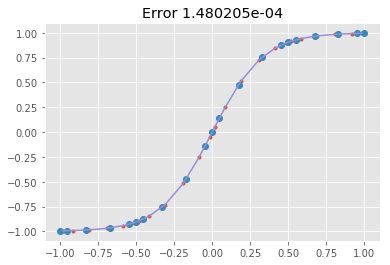

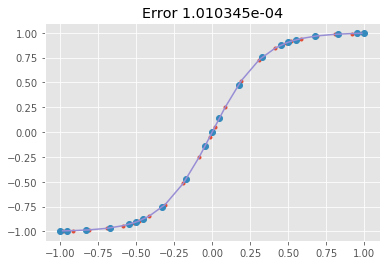

In [12]:
import scipy.sparse as sp
import scipy.sparse.linalg
from scipy.optimize import fsolve

class projection:
    def __init__(self, k):
        self.k = k
    def form(self, x, u, Du):
        return (u - self.exact(x), 0), ((1, 0), (0, 0))
    def exact(self, x):
        return numpy.tanh(self.k * x)

class laplacian:
    def __init__(self, k):
        self.k = k
    def form(self, x, u, Du):
        k = self.k
        manufactured = 2*k**2 * (numpy.tanh(k*x)**2 - 1) * numpy.tanh(k*x)
        return (manufactured, Du), ((0, 0), (0, 1))
    def exact(self, x):
        return numpy.tanh(self.k * x)

def fe1_solve(fe, nelem, form, dirichlet):
    x, Erestrict = fe1_mesh(fe, nelem)
    q, w = quad_gauss_legendre(fe.p+1)
    B, D = febasis(fe.xref, q)
    W = numpy.empty((nelem, len(w)))
    dXdx = numpy.empty((nelem, len(w)))
    xq = numpy.empty((nelem, len(w)))
    for e, E in enumerate(Erestrict):
        xq[e] = B @ x[E]
        dxdX = D @ x[E]
        W[e] = w * dxdX # Quadrature weight on physical element
        dXdx[e] = 1/dxdX
    bcmask = numpy.zeros(nelem * fe.p + 1, dtype=bool)
    for indices, _ in dirichlet:
        bcmask[indices] = True
        
    def residual(u):
        ubc = u.copy()
        for indices, func in dirichlet:
            ubc[indices] = func(x[indices])
        v = u - ubc
        for e, E in enumerate(Erestrict):
            ue = ubc[E]
            f, _ = form(xq[e], B @ ue, dXdx[e] * (D @ ue))
            vE = B.T @ (W[e] * f[0]) + D.T @ (dXdx[e] * W[e] * f[1])
            vE[bcmask[E]] = 0
            v[E] += vE
        return v
    
    def jacobian(u):
        ai = []
        aj = []
        aa = []
        for e, E in enumerate(Erestrict):
            ue = u[E]
            _, df = form(xq[e], B @ ue, dXdx[e] * (D @ ue))
            Ae = (B.T * W[e] * df[0][0] @ B
                  + B.T * W[e] * df[0][1] * dXdx[e] @ D
                  + D.T * dXdx[e] * W[e] * df[1][0] @ B
                  + D.T * dXdx[e] * W[e] * df[1][1] * dXdx[e] @ D)
            Ae[bcmask[E],:] = 0
            Ae[:,bcmask[E]] = 0
            ai += numpy.outer(E, numpy.ones_like(E)).flatten().tolist()
            aj += numpy.outer(numpy.ones_like(E), E).flatten().tolist()
            aa += Ae.flatten().tolist()
        N = len(u)
        for indices, _ in dirichlet:
            ipos = [i % N for i in indices]
            ai += ipos
            aj += ipos
            aa += numpy.ones_like(indices).tolist()
        A = sp.csr_matrix((aa, (ai, aj)), shape=(N,N))
        return A
    
    u0 = numpy.zeros(nelem * fe.p + 1) # initial guess
    u, nit = fsolve_newton(residual, jacobian, u0, verbose=True)
    # Return solution evaluated at quadrature points
    return x, u, xq.flatten(), (u[Erestrict] @ B.T).flatten()

def fe1_plot(x, u, xq, uq, exact=None):
    pyplot.plot(xq, uq, '.')
    pyplot.plot(x, u, 'o')
    if exact is not None:
        uexact = exact(xq)
        pyplot.plot(xq, uexact)
        error = numpy.linalg.norm(uq - uexact, numpy.inf)
        pyplot.title('Error {:8e}'.format(error));

fe = fe1(5)
prob = projection(3)
x, u, xq, uq = fe1_solve(fe, 4, prob.form, ())
fe1_plot(x, u, xq, uq, prob.exact)

pyplot.figure()
prob = laplacian(3)
x, u, xq, uq = fe1_solve(fe, 4, prob.form, [([0,-1], prob.exact)])
fe1_plot(x, u, xq, uq, prob.exact)

Newton 1 anorm 5.12e-15 rnorm 1.03e-14


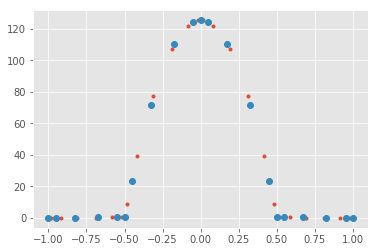

In [13]:
class vlaplacian:
    def __init__(self, k, eps = 1e-2):
        self.k = k
        self.eps = eps
    def form(self, x, u, Du):
        k = self.k
        forcing = 1
        diffusivity = numpy.where(numpy.abs(x) < .5, self.eps, 1)
        return (-forcing, diffusivity*Du), ((0, 0), (0, diffusivity))
    
prob = vlaplacian(3, 1e-3)
x, u, xq, uq = fe1_solve(fe, 4, prob.form, [([0,-1], numpy.zeros_like)])
fe1_plot(x, u, xq, uq)

Newton 1 anorm 8.02e+03 rnorm 1.62e+04
Newton 2 anorm 2.00e+03 rnorm 4.04e+03
Newton 3 anorm 5.01e+02 rnorm 1.01e+03
Newton 4 anorm 1.25e+02 rnorm 2.52e+02
Newton 5 anorm 3.12e+01 rnorm 6.29e+01
Newton 6 anorm 7.68e+00 rnorm 1.55e+01
Newton 7 anorm 1.82e+00 rnorm 3.66e+00
Newton 8 anorm 3.61e-01 rnorm 7.29e-01
Newton 9 anorm 3.77e-02 rnorm 7.60e-02
Newton 10 anorm 5.71e-04 rnorm 1.15e-03
Newton 11 anorm 1.18e-07 rnorm 2.38e-07
Newton 12 anorm 9.99e-15 rnorm 2.02e-14


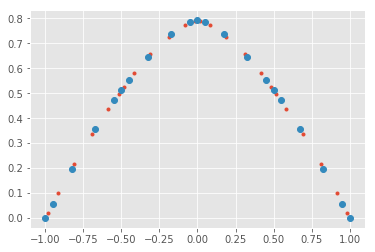

In [14]:
class plaplacian:
    def __init__(self, p, eps = 1e-2):
        self.p = p
        self.eps = eps
    def form(self, x, u, Du):
        p = self.p
        gamma = (.5*self.eps**2 + .5*Du*Du)
        dgamma = Du
        diffusivity = gamma**((p-2)/2)
        ddiffusivity = (p-2)/2 * gamma**((p-2)/2-1) * dgamma
        forcing = 1
        return (-forcing, diffusivity*Du), ((0, 0), (0, diffusivity + ddiffusivity*Du))
    
prob = plaplacian(3)
x, u, xq, uq = fe1_solve(fe, 4, prob.form, [([0,-1], numpy.zeros_like)])
fe1_plot(x, u, xq, uq)

## 2D

The main change will be in construction of a finite element basis.  We need to define a reference element and a quadrature (often called "cubature" in multiple dimensions).  This can be done by Kronecker product for quadrilaterals and hexahedra where we are interested in products of polynomials $p_n(x) q_n(y)$.  For multivariate polynomials of maximal degree (typically used for finite element methods on triangles and tetrahedra), the techniques are far more specialized.  A good modern source for computing such quadratures is [Witherden and Vincent (2015)](https://doi.org/10.1016/j.camwa.2015.03.017) and the associated [Polyquad](https://github.com/vincentlab/polyquad) software.

![Number of points for symmetric quadrature rules](figures/WitherdenVincent-Quadrature.png)

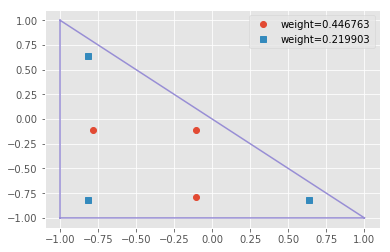

In [15]:
def tri_quad4():
    q = numpy.array([[ -0.10810301816807,   -0.78379396366386  ],
                     [ -0.78379396366386,   -0.10810301816807  ],
                     [ -0.10810301816807,   -0.10810301816807  ],
                     [-0.816847572980458,   0.633695145960917  ],
                     [ 0.633695145960917,  -0.816847572980458  ],
                     [-0.816847572980458,  -0.816847572980458  ]])
    w = numpy.array([ 0.446763179356023,
                      0.446763179356023,
                      0.446763179356023,
                      0.219903487310644,
                      0.219903487310644,
                      0.219903487310644])
    return q, w

q, w = tri_quad4()
pyplot.plot(q[:3,0], q[:3,1], 'o', label='weight={:6f}'.format(w[0]))
pyplot.plot(q[3:,0], q[3:,1], 's', label='weight={:6f}'.format(w[3]))
pyplot.triplot([-1, -1, 1], [1, -1, -1])
pyplot.legend();

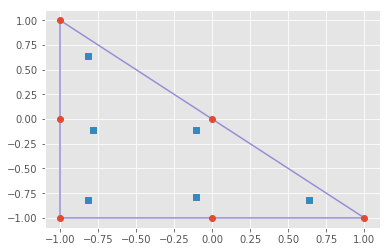

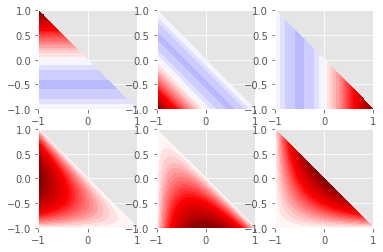

In [16]:
class fe2tri:
    def __init__(self, p):
        x1 = numpy.array([[-1, 1], [-1, -1], [1, -1]])
        x2 = numpy.array([[-1, 0], [0, -1], [0, 0]])
        if p == 1:
            x = x1
        elif p == 2:
            x = numpy.vstack([x1, x2])
        self.p = p
        self.xref = x
        self.q, self.w = tri_quad4() # Could use fewer points for p==1
        V, _ = self.prime(x)
        Vinv = numpy.linalg.inv(V)
        Bprime, Dprime = self.prime(q)
        self.B = Bprime @ Vinv
        self.D = Dprime @ Vinv

    def prime(self, x):
        V = numpy.ones((len(x), len(self.xref)))
        dV = numpy.zeros((len(x), 2, len(self.xref)))
        V[:,1] = x[:,0]
        V[:,2] = x[:,1]
        # dV[:,2*i] is derivative in x direction, dV[:,2*i+1] is in y-direction
        dV[:,0,1] = 1
        dV[:,1,2] = 1
        if self.p > 1:
            V[:,3] = x[:,0]**2
            V[:,4] = x[:,0]*x[:,1]
            V[:,5] = x[:,1]**2
            dV[:,0,3] = 2*x[:,0]
            dV[:,0,4] = x[:,1]
            dV[:,1,4] = x[:,0]
            dV[:,1,5] = 2*x[:,1]
        return V, dV
    
    def meshref(self):
        # Mesh for plotting on reference element
        x1 = numpy.linspace(-1, 1)
        xx, yy = numpy.meshgrid(x1, x1)
        for i,y in enumerate(yy):
            xx[i] = numpy.linspace(-1, -y[0])
        return numpy.vstack([xx.flatten(), yy.flatten()]).T
    
    def plot(self):
        pyplot.plot(self.xref[:,0], self.xref[:,1], 'o')
        pyplot.plot(self.q[:,0], self.q[:,1], 's')
        pyplot.triplot([-1, -1, 1], [1, -1, -1])
        
        X = self.meshref()
        Vinv = numpy.linalg.inv(self.prime(self.xref)[0])
        Bprime = self.prime(X)[0]
        B = Bprime @ Vinv
        pyplot.figure()
        for i in range(6):
            from matplotlib import cm
            pyplot.subplot(2, 3, i+1)
            pyplot.tricontourf(X[:,0], X[:,1], B[:,i], 30, cmap=cm.seismic, vmin=-1, vmax=1)

fe2tri(2).plot()

Upgrade to   meshio 1.10.3    available! (installed: 1.9.2)

To disable these checks, set SecondsBetweenChecks in /Users/coreynelson/Library/Application Support/pipdate/config.ini to -1.
Upgrade to   pygmsh 4.0.6    available! (installed: 4.0.3)

To disable these checks, set SecondsBetweenChecks in /Users/coreynelson/Library/Application Support/pipdate/config.ini to -1.


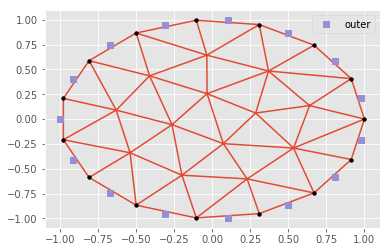

In [17]:
class Mesh:
    def __init__(self, lcar=.5, shape='circle', reshape_boundary=False):
        import pygmsh
        geom = pygmsh.built_in.Geometry()
        if shape == 'circle':
            geom.add_circle((0,0,0), 1, lcar)
        elif shape == 'rectangle':
            geom.add_rectangle(-1, 1, -.5, .5, 0, lcar)
        elif shape == 'eyes':
            holes = [geom.add_circle((c,0,0), .25, .25*lcar, make_surface=False)
                 for c in (-.5, .5)]
            geom.add_circle((0,0,0), 1, lcar, holes=holes)
        else:
            raise RuntimeError('Shape not recognized:', shape)
        points, elements, _, _, _ = pygmsh.generate_mesh(geom, verbose=False, dim=2)
        vtx = points[:,:2]
        tri = elements['triangle']
        # Gmsh doesn't guarantee consistent orientation so fix up any inverted elements
        orient = numpy.cross(vtx[tri[:,1]] - vtx[tri[:,0]],
                             vtx[tri[:,2]] - vtx[tri[:,1]]) < 0
        tri[orient] = tri[orient][:,[0,2,1]]
        # Create edges
        edges = tri[:,[0,1,1,2,2,0]].reshape((-1,2))
        edges.sort(axis=1)
        ind = numpy.lexsort((edges[:,1], edges[:,0]))
        edge2vertex, starts, perm, counts = numpy.unique(edges[ind], axis=0,
                        return_index=True, return_inverse=True, return_counts=True)
        cell2edge = numpy.empty(len(edges), dtype=int)
        cell2edge[ind] = perm
        cell2edge = cell2edge.reshape((-1, 3))
        edgenumbers, edgecount = numpy.unique(cell2edge.flatten(), return_counts=True)
        edgecenter = .5*(vtx[edge2vertex[:,0]] + vtx[edge2vertex[:,1]])
        
        centroids = (vtx[tri[:,0]] + vtx[tri[:,1]] + vtx[tri[:,2]]) / 3
        h = numpy.min(numpy.linalg.norm(numpy.kron([1,1,1], centroids).reshape((-1,2))
                                        - edgecenter[cell2edge.flatten()], axis=1))
        
        # Classify boundaries
        bedges = edgenumbers[edgecount == 1]
        if shape == 'eyes':
            def distance(c, r):
                return numpy.abs(numpy.linalg.norm(edgecenter[bedges] - c, axis=1) - r)
            mouter = distance((0,0), 1)
            mleft = distance((-.5,0), .25)
            mright = distance((.5,0), .25)
            boundary = dict(outer=bedges[mouter <= numpy.minimum(mleft, mright)],
                           left=bedges[mleft <= numpy.minimum(mouter, mright)],
                           right=bedges[mright <= numpy.minimum(mleft, mouter)])
        else:
            boundary = dict(outer=bedges)
        
        self.vtx = vtx
        self.tri = tri
        self.edge2vertex = edge2vertex
        self.cell2edge = cell2edge
        self.edgecenter = edgecenter
        self.boundary = boundary
        self.shape = shape
        self.nvtx = len(vtx)
        self.nface = len(edge2vertex)
        self.h = h
        if reshape_boundary:
            self.reshape_boundary()
    
    def reshape_boundary(self):
        def project_to_circle(label, c, r):
            edges = self.boundary[label]
            x = self.edgecenter[edges]
            self.edgecenter[edges] = c + r*(x-c) / numpy.linalg.norm(x-c, axis=1)[:,None]
        if self.shape == 'circle':
            project_to_circle('outer', (0,0), 1)
        elif self.shape == 'eyes':
            project_to_circle('outer', (0,0), 1)
            project_to_circle('left', (-.5,0), .25)
            project_to_circle('right', (.5,0), .25)
            
    def tri2(self):
        _, Erestrict = self.Erestrict(2)
        return Erestrict[:,[0,3,5, 1,4,3, 2,5,4, 3,4,5]].reshape(-1,3)
    
    def Erestrict(self, p):
        if p == 1:
            return self.vtx, self.tri
        elif p == 2:
            x = numpy.vstack([self.vtx, self.edgecenter])
            Erestrict = numpy.hstack([self.tri, self.nvtx+self.cell2edge])
            return x, Erestrict
        raise RuntimeError('Not implemented for order', p)
    
    def Frestrict(self, p):
        if p == 1:
            return self.edge2vertex
        elif p == 2:
            return numpy.hstack([self.edge2vertex,
                                 self.nvtx + numpy.arange(self.nface)[:,None]])
        raise RuntimeError('Not implemented for order', p)
    
    def plotmesh(self):
        pyplot.triplot(self.vtx[:,0], self.vtx[:,1], triangles=self.tri)
        x, _ = self.Erestrict(2)
        Frestrict = self.Frestrict(2)
        for label, faces in self.boundary.items():
            xF = x[Frestrict[faces,2]]
            pyplot.plot(xF[:,0], xF[:,1], 's', label=label)
            xFv = x[Frestrict[faces,:2].flatten()]
            pyplot.plot(xFv[:,0], xFv[:,1], '.k')
        pyplot.legend()

mesh = Mesh(shape='circle', reshape_boundary=True)
mesh.plotmesh()

Newton 1 anorm 3.32e-17 rnorm 5.71e-18
Newton 1 anorm 1.61e-15 rnorm 4.31e-16


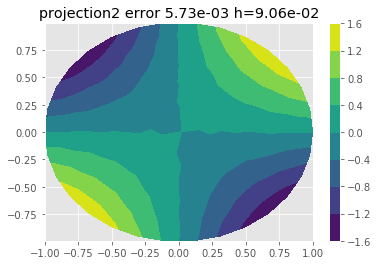

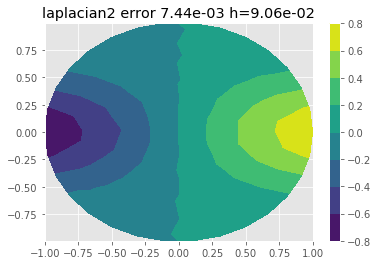

In [18]:
class projection2:
    def __init__(self, k):
        self.k = k
    def form(self, x, u, Du):
        return (u - self.exact(x), 0*Du), ((1, 0), (0, 0))
    def exact(self, x):
        return self.k * x[:,0] * x[:,1]
        return numpy.tanh(self.k * x[:,0])

class laplacian2:
    def __init__(self, k=1, exact='1'):
        self.k = k
        self.exact = getattr(self, 'exact_' + exact)
        self.forcing = getattr(self, 'forcing_' + exact)
    def form(self, x, u, Du):
        return (self.forcing(x), self.k*Du), ((0, 0), (0, self.k*numpy.eye(2)[None,:,:]))
    def exact_1(self, x):
        return x[:,0] + x[:,1]
    def forcing_1(self, x):
        return 0
    def exact_2(self, x):
        return x[:,0]*x[:,1] + 2*x[:,0]**2 - x[:,1]**2 + x[:,1]
    def forcing_2(self, x):
        return 2
    def exact_warp(self, xx):
        from numpy import tanh, exp
        k, x, y = self.k, xx[:,0], xx[:,1]
        return tanh(k*x) * exp(-4*y**2)
    def forcing_warp(self, xx):
        from numpy import tanh, exp
        k, x, y = self.k, xx[:,0], xx[:,1]
        return 2*k**2*(tanh(k*x)**2 - 1)*exp(-4*y**2)*tanh(k*x) + 8*(8*y**2 - 1)*exp(-4*y**2)*tanh(k*x)

def fe2_geom(fe, mesh):
    x, Erestrict = mesh.Erestrict(fe.p)
    nelem = len(Erestrict)
    Q = len(fe.w)
    B, D = fe.B, fe.D
    W = numpy.empty((nelem, Q))
    dXdx = numpy.empty((nelem, Q, 2, 2))
    xq = numpy.empty((nelem, Q, 2))
    for e, E in enumerate(Erestrict):
        xE = x[E,:]
        xq[e] = B @ xE
        dxdX = D @ xE # 2x2 matrices at each quadrature point
        det = numpy.linalg.det(dxdX)
        W[e] = w * det # Quadrature weight on physical element
        dXdx[e] = numpy.linalg.inv(dxdX)
    return xq, W, dXdx
    
def fe2_solve(fe, mesh, form, dirichlet={}, spy=False):
    x, Erestrict = mesh.Erestrict(fe.p)
    Frestrict = mesh.Frestrict(fe.p)
    Ndof = len(x)
    B, D = fe.B, fe.D
    xq, W, dXdx = fe2_geom(fe, mesh)
    dirichletidx = []
    bcmask = numpy.zeros(Ndof, dtype=bool)
    for label, func in dirichlet.items():
        indices = Frestrict[mesh.boundary[label]].flatten()
        dirichletidx.append((label, indices, func))
        bcmask[indices] = True
    
    def project_dirichlet(u): # Affine projector into space satisfying Dirichlet BC
        ubc = u.copy()
        for label, indices, func in dirichletidx:
            ubc[indices] = func(x[indices])
        return ubc

    def residual(u):
        ubc = project_dirichlet(u)
        v = u - ubc
        for e, E in enumerate(Erestrict):
            uE = ubc[E]
            uq = B @ uE
            Dxuq = numpy.einsum('ixX,iX->ix', dXdx[e], D @ uE)
            f, _ = form(xq[e], uq, Dxuq)
            vE = B.T @ (W[e] * f[0]) + numpy.einsum('iXp,ixX,ix->p',
                                                    D, dXdx[e], W[e,:,None] * f[1])
            vE[bcmask[E]] = 0
            v[E] += vE
        return v

    def jacobian(u):
        ubc = project_dirichlet(u)
        ai = []
        aj = []
        aa = []
        for e, E in enumerate(Erestrict):
            uE = ubc[E]
            Dx = numpy.einsum('ixX,iXp->ixp', dXdx[e], D)
            _, df = form(xq[e], B @ uE, Dx @ uE)
            Ae = (numpy.einsum('qi,q,qj->ij', B, W[e] * df[0][0], B)
                  + numpy.einsum('qi,qy,qyj->ij', B, W[e,:,None] * df[0][1], Dx)
                  + numpy.einsum('qxi,qx,qj->ij', Dx, W[e,:,None] * df[1][0], B)
                  + numpy.einsum('qxi,qxy,qyj->ij', Dx, W[e,:,None,None] * df[1][1], Dx))
            Ae[bcmask[E],:] = 0
            Ae[:,bcmask[E]] = 0
            ai += numpy.outer(E, numpy.ones_like(E)).flatten().tolist()
            aj += numpy.outer(numpy.ones_like(E), E).flatten().tolist()
            aa += Ae.flatten().tolist()
        bcidx = numpy.where(bcmask)[0].tolist()
        ai += bcidx
        aj += bcidx
        aa += numpy.ones_like(bcidx).tolist()
        A = sp.csr_matrix((aa, (ai, aj)), shape=(Ndof,Ndof))
        if spy:
            pyplot.spy(A)
        return A
    
    u0 = numpy.zeros(Ndof) # initial guess
    u, nit = fsolve_newton(residual, jacobian, u0, verbose=True)
    return x, u

mesh = Mesh(.5, reshape_boundary=True)
fe = fe2tri(2)
for prob in [projection2(3), laplacian2(exact='warp')]:
    x, u = fe2_solve(fe, mesh, prob.form, dict(outer=prob.exact), spy=False)
    pyplot.figure()
    pyplot.tricontourf(x[:,0], x[:,1], u)
    error = numpy.linalg.norm(u - prob.exact(x))
    pyplot.title('{} error {:8.2e} h={:.2e}'.format(type(prob).__name__, error, mesh.h))
    pyplot.colorbar();

In [19]:
def fe2_Lpnorm_error(fe, mesh, u, exact, p=2):
    x, Erestrict = mesh.Erestrict(fe.p)
    B = fe.B
    xq, W, dXdx = fe2_geom(fe, mesh)
    isum = 0
    for e,E in enumerate(Erestrict):
        uq = B @ u[E]
        isum += numpy.sum(W[e] * numpy.abs((uq - exact(xq[e])))**p)
    return isum**(1/p)

fe2_Lpnorm_error(fe, mesh, u, prob.exact)

0.0052247940091276878

Newton 1 anorm 1.26e-15 rnorm 3.69e-16
Newton 1 anorm 1.90e-15 rnorm 5.34e-16
Newton 1 anorm 3.09e-15 rnorm 6.99e-16
Newton 1 anorm 7.47e-15 rnorm 1.35e-15
Newton 1 anorm 1.42e-14 rnorm 1.84e-15
Newton 1 anorm 2.66e-14 rnorm 2.56e-15


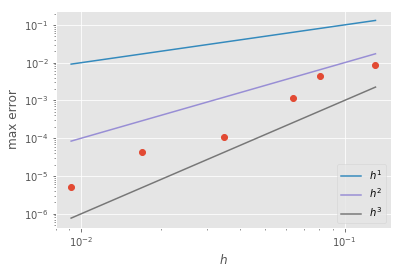

In [20]:
fe = fe2tri(2)
prob = laplacian2(exact='warp')
meshes = [Mesh(lcar, shape='circle', reshape_boundary=True)
          for lcar in numpy.geomspace(.05, 1, 6)[::-1]]
def err(mesh):
    x, u = fe2_solve(fe, mesh, prob.form, dict(outer=prob.exact))
    enorm = fe2_Lpnorm_error(fe, mesh, u, prob.exact)
    enorm = numpy.linalg.norm(u - prob.exact(x), numpy.inf)
    return [mesh.h, enorm]
r = numpy.array([err(mesh) for mesh in meshes])
hs, es = r[:,0], r[:,1]
pyplot.loglog(hs, es, 'o')
for p in (1,2,3):
    pyplot.loglog(hs, hs**p, label='$h^{}$'.format(p))
pyplot.xlabel('$h$')
pyplot.ylabel('max error')
pyplot.legend();

## Dirichlet boundary conditions

We have implemented boundary conditions using the following methodology.  Note that the true solution space $V$ for the weak form does not include any degrees of freedom on the Dirichlet boundary.  The ansatz space
$$\bar V = V \times V_{\Gamma} $$
is the product of this interior space with the space of functions on the Dirichlet boundary.
Specifically, $\bar V$ includes all discrete functions on $\bar \Omega$ regardless of whether they satisfy the boundary condition.  Now define

* $R_0: \bar V \to V_0$ restricts to the subspace with 0 at Dirichlet boundary,
* $R_D: \bar V \to V_D$ projects into the affine subspace with inhomogeneous Dirichlet boundary conditions.

Now given an interior residual $\tilde F(u)$, we extend it to a residual including boundary conditions as
$$ F(u) = R_0 \tilde F(R_D u) + (u - R_D u) . $$
The left term has no dependence on $u|_\Gamma$ (because of $R_D u$) so those columns of the Jacobian are zero.
It produces no contribution on the boundary (because of $R_0$) so those rows of the Jacobian are zero.
The Jacobian of the second term is the identity on the Dirichlet boundary degrees of freedom.

# Homework 5: due 2017-12-15

We consider steady-state flow in a fully saturated porous medium.  We will assume constant porosity and viscosity for simplicity, leading to [Darcy's law](https://en.wikipedia.org/wiki/Darcy%27s_law) producing a flux
$$ q = -\kappa \nabla p $$
in terms of pressure $p$ and permeability $\kappa$.
Conservation of mass yields a Laplacian
$$ \nabla\cdot q = -\nabla\cdot \big( \kappa \nabla p \big) = 0 . $$
The velocity of the fluid is
$$ u = \frac q \phi $$
where $\phi \in (0,1]$ is porosity.

Our flow will take place on the 2D unit disc with two holes removed
$$ \left\{ x \in \mathbb R^2 : |x|<1, \big|x-(1/2,0)| > 1/4\big|, \big|x-(-1/2,0)| > 1/4\big|  \right\} . $$
The outer boundary is Neumann, corresponding to an impermeable boundary.
The left "hole" is our inejection with a relative pressure of 1 and the right is extraction with a relative pressure of 0.
We can solve for pressure as follows.

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 1.13e-14 rnorm 9.96e-16


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'triangles'
  s)


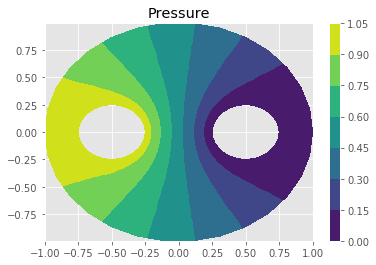

In [21]:
mesh = Mesh(shape='eyes', reshape_boundary=True)
fe = fe2tri(2)
prob = laplacian2()
x, pressure = fe2_solve(fe, mesh, prob.form, dict(left=lambda x:0*x[:,0]+1, right=lambda x:0*x[:,0]))
pyplot.tricontourf(x[:,0], x[:,1], pressure, triangles=mesh.tri2())
pyplot.title('Pressure')
pyplot.colorbar();

The velocity field can be computed by taking the gradient of pressure and dividing by permeability.
Now suppose that the fluid being injected at the left hole is hot while the outflow is a colder heat sink.
Temperature will satisfy the advection-diffusion equation (with appropriate choice of units)
$$ \nabla\cdot \big( - \nabla T + u T \big) = 0 $$
with boundary conditions $T=1$ at the left (inflow) hole, $T=0$ at the right (outflow) hole, and Neumann conditions at the (insulated) outer boundary.
The homework is to solve for temperature using the velocity field defined by the pressure solution above.

* You will need to modify `fe2_solve` so that you can evaluate velocity at the quadrature points.
* You will need to write a `form` function that implements the weak form of the advection-diffusion equation for temperature.

With respect to your numerically computed solutions, think about the following questions.

1. What is the order of accuracy of $p$, $u$, and $T$ for linear `fe2tri(1)` and quadratic `fe2tri(2)` elements? Rather than interpolating to compare in a norm, you can compare by computing moments of the error, such as
$$ \int_\Omega x (u_{2h} - u_h)(x,y) = \int_\Omega x u_{2h}(x,y) - \int_\Omega x u_h(x,y), $$
where the two integrals on the right can be carried out on the natural quadrature of each mesh independently.

2. When porosity $\phi$ decreases (at fixed permeability), the velocity increases.  Can you obtain an accurate solution for $T$ for any value of $\phi$ or is there a relationship between $\phi$ and the grid size $h$?


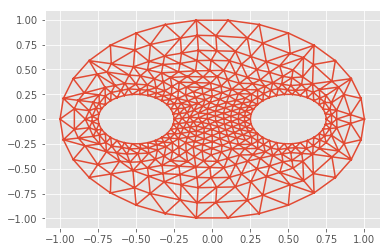

In [22]:
pyplot.triplot(x[:,0], x[:,1], triangles=mesh.tri2());